# Fase 2: Model Performance - Validación Híbrida Ventanas

**Objetivo**: Medir edge económico real de ventanas candidatas usando LightGBM.

**Método**: Model Performance (económicamente relevante)
- LightGBM classifier para predecir profit/loss
- Métricas: AUC + Edge (expected weighted return)
- Score compuesto: (Edge × AUC) / log(n_bars)

**Inputs**: 
- `phase1_results.pkl` (info_results)
- `processed/dataset_pilot50/` (D.4 features enriquecidos)

**Output**: `phase2_results.pkl` con ventanas óptimas

**Tiempo estimado**: 20-40 min (2 eventos × 6 ventanas)

## 0. Setup

In [1]:
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from typing import Dict, List
import pickle
import warnings
warnings.filterwarnings('ignore')

# Config
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Paths (CORREGIDO: usa dataset_pilot50 con features enriquecidos)
DATASET_ROOT = Path('../../../../processed/dataset_pilot50')
OUTPUT_DIR = Path('.')

print(f"Dataset dir exists: {DATASET_ROOT.exists()}")
if not DATASET_ROOT.exists():
    print("\n⚠️  WARNING: Dataset directory not found!")
    print("   Ejecuta D.4 build_ml_daser.py primero:")
    print("   python scripts/fase_D_creando_DIB_VIB/build_ml_daser.py \\")
    print("     --bars-root processed/dib_bars/pilot50_validation \\")
    print("     --labels-root processed/labels_pilot50 \\")
    print("     --weights-root processed/weights_pilot50 \\")
    print("     --outdir processed/dataset_pilot50 \\")
    print("     --bar-file dollar_imbalance.parquet --parallel 12 --resume --split none")
    raise FileNotFoundError("Dataset enriquecido no encontrado")

print(f"Output dir: {OUTPUT_DIR.absolute()}")

Dataset dir exists: True
Output dir: D:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\F_Event_detectors_E1_E11\notebooks


## 1. Cargar Resultados Fase 1

In [2]:
# Cargar resultados de Information Theory
phase1_file = OUTPUT_DIR / 'phase1_results.pkl'

if not phase1_file.exists():
    raise FileNotFoundError(
        f"No se encontró {phase1_file}. "
        "Ejecuta phase1_information_theory.ipynb primero."
    )

with open(phase1_file, 'rb') as f:
    phase1 = pickle.load(f)

# Extraer datos
info_results = phase1['info_results']
wl_expanded = phase1['wl_expanded']
events_available = phase1['events_available']
suggested_windows = phase1['suggested_windows']

print("✓ Resultados Fase 1 cargados correctamente")
print(f"  - Eventos con MI: {len(info_results)}")
print(f"  - Event occurrences: {wl_expanded.height:,}")
print(f"  - Ventanas sugeridas: {len([w for w in suggested_windows.values() if w])}")
print(f"\nEventos disponibles: {list(info_results.keys())}")

✓ Resultados Fase 1 cargados correctamente
  - Eventos con MI: 3
  - Event occurrences: 44,795
  - Ventanas sugeridas: 3

Eventos disponibles: ['E10_FirstGreenBounce', 'E11_VolumeBounce', 'E1_VolExplosion']


## 2. Configuración Ventanas Candidatas

In [3]:
# Ventanas candidatas (pre_days, post_days)
CANDIDATE_WINDOWS = [
    (0, 0),  # Solo día evento
    (1, 0),  # 1 día antes
    (0, 1),  # 1 día después
    (1, 1),  # ±1 simétrico
    (2, 1),  # Más anticipación
    (1, 2),  # Más confirmación
    (2, 2),  # ±2 simétrico
    (3, 1),  # Build-up largo, poco post
    (1, 3),  # Poco pre, unwind largo
    (3, 2),  # Asimétrico amplio
    (2, 3),  # Inverso
    (3, 3),  # ±3 completo (baseline)
]

# CONFIGURACIÓN: Subset para prueba rápida
EVENTS_SUBSET = list(info_results.keys())[:2]  # Cambiar a list(info_results.keys()) para todos
WINDOWS_SUBSET = CANDIDATE_WINDOWS[:6]  # Cambiar a CANDIDATE_WINDOWS para todas

print(f"Ventanas candidatas: {len(WINDOWS_SUBSET)}")
print(f"Eventos a testear: {len(EVENTS_SUBSET)}")
print(f"Total combinaciones: {len(WINDOWS_SUBSET) * len(EVENTS_SUBSET)}")
print(f"\nEventos: {EVENTS_SUBSET}")

Ventanas candidatas: 6
Eventos a testear: 2
Total combinaciones: 12

Eventos: ['E10_FirstGreenBounce', 'E11_VolumeBounce']


## 3. Funciones de Carga Dataset (CORREGIDAS)

In [4]:
def load_day_dataset_full(ticker: str, day: datetime.date) -> pl.DataFrame:
    """
    Carga dataset enriquecido (features + labels + weights).
    
    REQUIERE: D.4 build_ml_daser.py ejecutado previamente.
    Lee desde processed/dataset_pilot50/daily/ con features enriquecidos.
    """
    # CRÍTICO: dataset_pilot50 tiene subdirectorio "daily/"
    dataset_file = DATASET_ROOT / "daily" / ticker / f"date={day.isoformat()}" / "dataset.parquet"
    
    if not dataset_file.exists():
        return None
    
    df = pl.read_parquet(dataset_file)
    
    # Añadir columnas de contexto si no existen
    if 'ticker' not in df.columns:
        df = df.with_columns([
            pl.lit(ticker).alias('ticker'),
            pl.lit(day).alias('session_day')
        ])
    
    return df


def build_dataset_for_window(
    event_code: str,
    pre_days: int,
    post_days: int,
    max_samples: int = 1000
) -> pl.DataFrame:
    """
    Construye dataset completo para una ventana específica.
    """
    subset = wl_expanded.filter(pl.col('event_code') == event_code)
    
    if subset.height > max_samples:
        subset = subset.sample(max_samples, seed=42)
    
    rows = []
    
    for row in subset.iter_rows(named=True):
        ticker = row['ticker']
        t0 = row['date']
        
        for offset in range(-pre_days, post_days + 1):
            d = t0 + timedelta(days=offset)
            df_day = load_day_dataset_full(ticker, d)
            
            if df_day is not None:
                df_day = df_day.with_columns([
                    pl.lit(event_code).alias('event_code'),
                    pl.lit(offset).alias('rel_day'),
                    pl.lit(t0).alias('event_day')
                ])
                rows.append(df_day)
    
    if not rows:
        return None
    
    return pl.concat(rows)


print("✓ Funciones de dataset completo definidas")

✓ Funciones de dataset completo definidas


## 4. Función de Evaluación Económica

In [5]:
def evaluate_window_performance(
    df: pl.DataFrame,
    feature_cols: List[str]
) -> Dict:
    """
    Evalúa performance económico de una ventana.
    
    Returns:
        {
            'auc': float,
            'edge': float (expected weighted return),
            'n_bars': int,
            'n_days': int
        }
    """
    if df is None or df.height < 100:
        return {
            'auc': None,
            'edge': None,
            'n_bars': 0,
            'n_days': 0
        }
    
    # Filtrar filas válidas
    required_cols = feature_cols + ['label', 'weight', 'ret_at_outcome']
    base = df.drop_nulls(required_cols)
    
    if base.height < 100:
        return {'auc': None, 'edge': None, 'n_bars': base.height, 'n_days': 0}
    
    # Preparar datos
    X = np.column_stack([base[col].to_numpy() for col in feature_cols])
    y = (base['label'].to_numpy() > 0).astype(int)  # Binary: profit vs no-profit
    w = base['weight'].to_numpy()
    returns = base['ret_at_outcome'].to_numpy()
    
    # Entrenar modelo simple
    model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        verbose=-1
    )
    
    try:
        model.fit(X, y, sample_weight=w)
    except Exception as e:
        print(f"Error training model: {e}")
        return {'auc': None, 'edge': None, 'n_bars': base.height, 'n_days': 0}
    
    # Predicciones
    y_pred = model.predict_proba(X)[:, 1]
    
    # Métrica 1: AUC
    try:
        auc = roc_auc_score(y, y_pred, sample_weight=w)
    except:
        auc = 0.5
    
    # Métrica 2: Edge económico
    # Expected return si tradeamos cuando pred > 0.5
    trade_mask = (y_pred >= 0.5)
    
    if trade_mask.sum() == 0:
        edge = 0.0
    else:
        edge = (
            (returns[trade_mask] * w[trade_mask]).sum() /
            w[trade_mask].sum()
        )
    
    # Métricas de coste
    n_days = base['session_day'].n_unique()
    
    return {
        'auc': float(auc),
        'edge': float(edge),
        'n_bars': int(base.height),
        'n_days': int(n_days)
    }


print("✓ Función de evaluación económica definida")

✓ Función de evaluación económica definida


## 5. Grid Search: Ventanas × Eventos

In [6]:
# Features a usar (generados por D.4 build_ml_daser.py)
FEATURE_COLS = [
    'ret_1', 'range_norm', 'vol_f', 'dollar_f', 'imb_f',
    'ret_1_ema10', 'ret_1_ema30', 'range_norm_ema20',
    'vol_f_ema20', 'dollar_f_ema20', 'imb_f_ema20',
    'vol_z20', 'dollar_z20', 'n'
]

MAX_SAMPLES = 300  # Sample por evento (aumentar a 500-1000 para más precisión)

phase2_results = []

print(f"\nEjecutando grid search: {len(EVENTS_SUBSET)} eventos × {len(WINDOWS_SUBSET)} ventanas")
print(f"Total combinaciones: {len(EVENTS_SUBSET) * len(WINDOWS_SUBSET)}")
print(f"Max samples por evento: {MAX_SAMPLES}\n")

for event in EVENTS_SUBSET:
    print(f"\n{'='*60}")
    print(f"Evento: {event}")
    print(f"{'='*60}")
    
    for pre, post in WINDOWS_SUBSET:
        print(f"\n  Ventana [{pre}, {post}]...", end=' ')
        
        # Construir dataset
        ds = build_dataset_for_window(event, pre, post, max_samples=MAX_SAMPLES)
        
        # Evaluar
        if ds is None:
            metrics = {'auc': None, 'edge': None, 'n_bars': 0, 'n_days': 0}
        else:
            metrics = evaluate_window_performance(ds, FEATURE_COLS)
        
        # Print con manejo correcto de None
        auc_str = f"{metrics['auc']:.3f}" if metrics['auc'] is not None else 'N/A'
        edge_str = f"{metrics['edge']:.4f}" if metrics['edge'] is not None else 'N/A'
        print(f"AUC={auc_str}, Edge={edge_str}, n_bars={metrics['n_bars']:,}")
        
        phase2_results.append({
            'event': event,
            'pre_days': pre,
            'post_days': post,
            **metrics
        })

res_df = pl.DataFrame(phase2_results)

print("\n" + "="*60)
print("✓ Grid search completado")
print(f"Total resultados: {len(phase2_results)}")
print("="*60)

res_df


Ejecutando grid search: 2 eventos × 6 ventanas
Total combinaciones: 12
Max samples por evento: 300


Evento: E10_FirstGreenBounce

  Ventana [0, 0]... 

AUC=0.963, Edge=0.0121, n_bars=6,137

  Ventana [1, 0]... 

AUC=0.942, Edge=0.0070, n_bars=10,826

  Ventana [0, 1]... 

AUC=0.940, Edge=0.0059, n_bars=10,759

  Ventana [1, 1]... 

AUC=0.928, Edge=0.0040, n_bars=15,448

  Ventana [2, 1]... 

AUC=0.921, Edge=0.0030, n_bars=18,561

  Ventana [1, 2]... 

AUC=0.918, Edge=0.0043, n_bars=19,211

Evento: E11_VolumeBounce

  Ventana [0, 0]... 

AUC=0.975, Edge=0.0209, n_bars=6,750

  Ventana [1, 0]... 

AUC=0.962, Edge=0.0116, n_bars=10,456

  Ventana [0, 1]... 

AUC=0.967, Edge=0.0151, n_bars=10,536

  Ventana [1, 1]... 

AUC=0.952, Edge=0.0097, n_bars=14,242

  Ventana [2, 1]... 

AUC=0.939, Edge=0.0071, n_bars=16,164

  Ventana [1, 2]... 

AUC=0.943, Edge=0.0082, n_bars=16,575

✓ Grid search completado
Total resultados: 12


event,pre_days,post_days,auc,edge,n_bars,n_days
str,i64,i64,f64,f64,i64,i64
"""E10_FirstGreenBounce""",0,0,0.962636,0.012051,6137,291
"""E10_FirstGreenBounce""",1,0,0.941606,0.006978,10826,497
"""E10_FirstGreenBounce""",0,1,0.940014,0.005942,10759,508
"""E10_FirstGreenBounce""",1,1,0.928223,0.00395,15448,703
"""E10_FirstGreenBounce""",2,1,0.921253,0.002951,18561,835
…,…,…,…,…,…,…
"""E11_VolumeBounce""",1,0,0.962224,0.011617,10456,515
"""E11_VolumeBounce""",0,1,0.96719,0.015145,10536,504
"""E11_VolumeBounce""",1,1,0.952352,0.009721,14242,726


## 6. Selección Ventana Óptima por Evento

In [7]:
# Calcular score compuesto: (edge × AUC) / log(n_bars)
res_df = res_df.with_columns([
    (
        (pl.col('edge').fill_null(0.0).abs() * pl.col('auc').fill_null(0.5)) /
        (pl.col('n_bars').cast(pl.Float64).log().fill_null(1.0))
    ).alias('score')
])

# Mejor ventana por evento
best_per_event = (
    res_df
    .sort(['event', 'score'], descending=[False, True])
    .group_by('event')
    .head(1)
)

print("\n" + "="*80)
print("VENTANAS ÓPTIMAS POR EVENTO (Fase 2: Model Performance)")
print("="*80)
print(best_per_event.select([
    'event', 'pre_days', 'post_days', 'auc', 'edge', 'n_bars', 'score'
]).to_pandas().to_string(index=False))
print("="*80)

best_per_event


VENTANAS ÓPTIMAS POR EVENTO (Fase 2: Model Performance)
               event  pre_days  post_days      auc     edge  n_bars    score
E10_FirstGreenBounce         0          0 0.962636 0.012051    6137 0.001330
    E11_VolumeBounce         0          0 0.975119 0.020933    6750 0.002315


event,pre_days,post_days,auc,edge,n_bars,n_days,score
str,i64,i64,f64,f64,i64,i64,f64
"""E10_FirstGreenBounce""",0,0,0.962636,0.012051,6137,291,0.00133
"""E11_VolumeBounce""",0,0,0.975119,0.020933,6750,288,0.002315


## 7. Visualización Comparativa

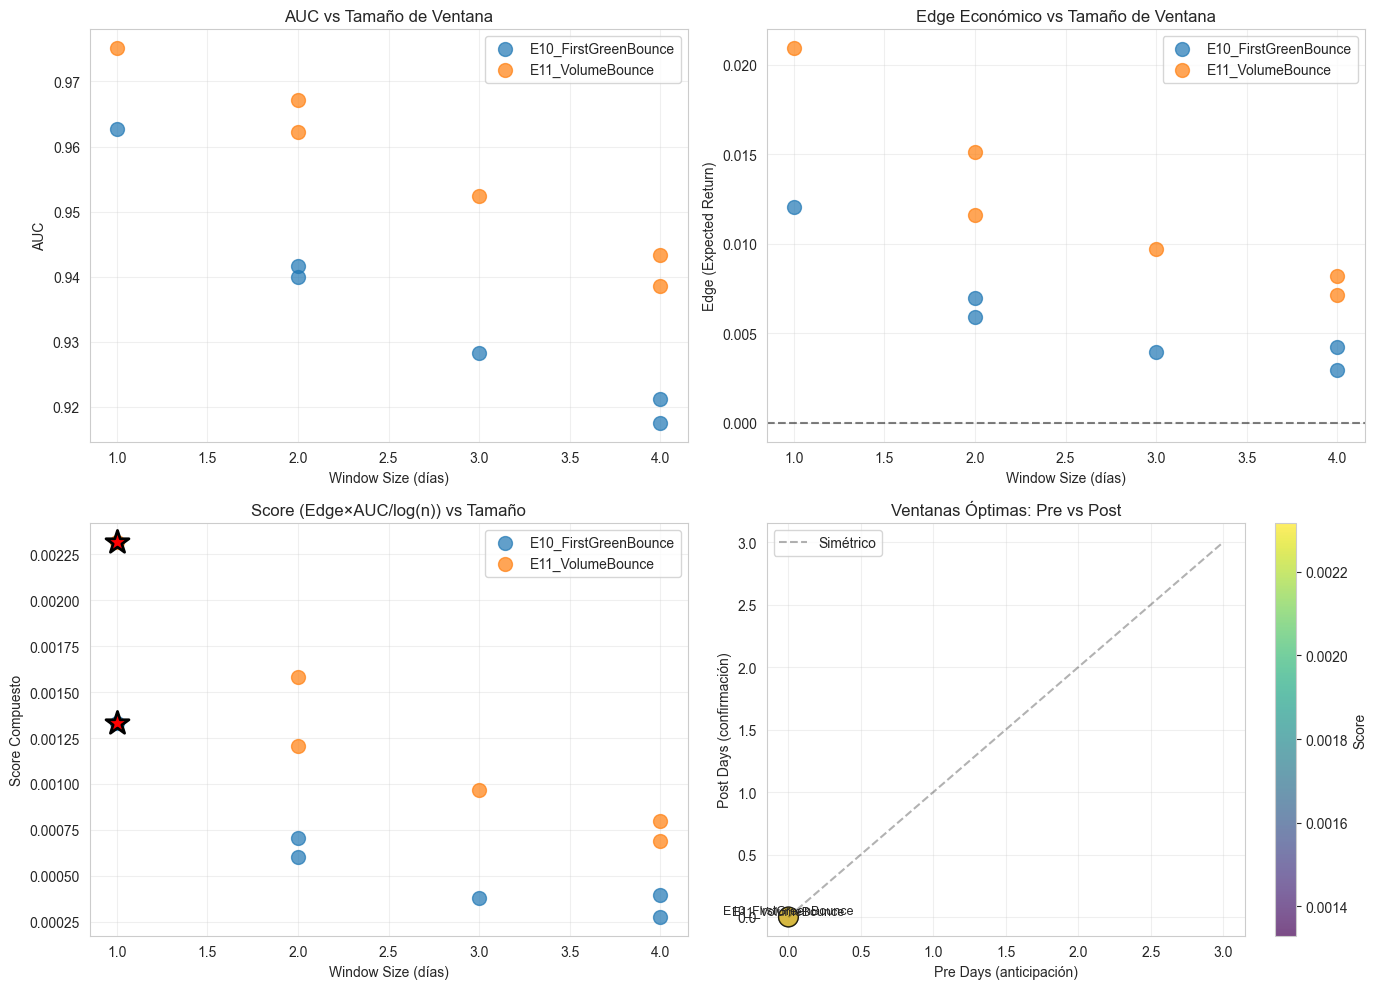

✓ Gráfico guardado: window_optimization_phase2.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Convertir a pandas para plotting
res_pd = res_df.to_pandas()
res_pd['window_size'] = res_pd['pre_days'] + res_pd['post_days'] + 1

# 1. AUC vs Window Size
ax = axes[0, 0]
for event in EVENTS_SUBSET:
    subset = res_pd[res_pd['event'] == event]
    ax.scatter(subset['window_size'], subset['auc'], label=event, alpha=0.7, s=100)

ax.set_xlabel('Window Size (días)')
ax.set_ylabel('AUC')
ax.set_title('AUC vs Tamaño de Ventana')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Edge vs Window Size
ax = axes[0, 1]
for event in EVENTS_SUBSET:
    subset = res_pd[res_pd['event'] == event]
    ax.scatter(subset['window_size'], subset['edge'], label=event, alpha=0.7, s=100)

ax.set_xlabel('Window Size (días)')
ax.set_ylabel('Edge (Expected Return)')
ax.set_title('Edge Económico vs Tamaño de Ventana')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 3. Score vs Window Size
ax = axes[1, 0]
for event in EVENTS_SUBSET:
    subset = res_pd[res_pd['event'] == event]
    ax.scatter(subset['window_size'], subset['score'], label=event, alpha=0.7, s=100)
    # Marcar mejor
    best = subset.loc[subset['score'].idxmax()]
    ax.scatter(best['window_size'], best['score'], 
               color='red', s=300, marker='*', edgecolors='black', linewidths=2)

ax.set_xlabel('Window Size (días)')
ax.set_ylabel('Score Compuesto')
ax.set_title('Score (Edge×AUC/log(n)) vs Tamaño')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Ventanas óptimas (pre vs post)
ax = axes[1, 1]
best_pd = best_per_event.to_pandas()
scatter = ax.scatter(best_pd['pre_days'], best_pd['post_days'], s=200, alpha=0.7, 
                     c=best_pd['score'], cmap='viridis', edgecolors='black', linewidths=1)
plt.colorbar(scatter, ax=ax, label='Score')

for _, row in best_pd.iterrows():
    ax.annotate(row['event'], (row['pre_days'], row['post_days']), 
                ha='center', va='bottom', fontsize=9)

ax.plot([0, 3], [0, 3], 'k--', alpha=0.3, label='Simétrico')
ax.set_xlabel('Pre Days (anticipación)')
ax.set_ylabel('Post Days (confirmación)')
ax.set_title('Ventanas Óptimas: Pre vs Post')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('window_optimization_phase2.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: window_optimization_phase2.png")

## 8. Comparación con Ventanas Cualitativas (F.3)

In [9]:
# Ventanas cualitativas de F.3
EVENT_WINDOWS_QUALITATIVE = {
    'E1_VolExplosion': 1,
    'E2_GapUp': 2,
    'E3_PriceSpikeIntraday': 1,
    'E4_Parabolic': 3,
    'E5_BreakoutATH': 2,
    'E6_MultipleGreenDays': 2,
    'E7_FirstRedDay': 2,
    'E8_GapDownViolent': 2,
    'E9_CrashIntraday': 1,
    'E10_FirstGreenBounce': 1,
    'E11_VolumeBounce': 2
}

comparison = []
for _, row in best_per_event.to_pandas().iterrows():
    event = row['event']
    pre_emp = row['pre_days']
    post_emp = row['post_days']
    size_emp = pre_emp + post_emp + 1
    
    if event in EVENT_WINDOWS_QUALITATIVE:
        qual_window = EVENT_WINDOWS_QUALITATIVE[event]
        size_qual = 2 * qual_window + 1
        diff = size_emp - size_qual
        
        comparison.append({
            'Evento': event,
            'Empírico [pre,post]': f"[{pre_emp},{post_emp}]",
            'Empírico Size': size_emp,
            'Cualitativo ±N': f"±{qual_window}",
            'Cualitativo Size': size_qual,
            'Diferencia': diff,
            'Status': 'Match' if diff == 0 else ('Más pequeño' if diff < 0 else 'Más grande')
        })

comp_df = pd.DataFrame(comparison)

print("\n" + "="*80)
print("COMPARACIÓN: VENTANAS EMPÍRICAS vs CUALITATIVAS (F.3)")
print("="*80)
if len(comp_df) > 0:
    print(comp_df.to_string(index=False))
else:
    print("No hay eventos en común con F.3 en el subset actual")
print("="*80)


COMPARACIÓN: VENTANAS EMPÍRICAS vs CUALITATIVAS (F.3)
              Evento Empírico [pre,post]  Empírico Size Cualitativo ±N  Cualitativo Size  Diferencia      Status
E10_FirstGreenBounce               [0,0]              1             ±1                 3          -2 Más pequeño
    E11_VolumeBounce               [0,0]              1             ±2                 5          -4 Más pequeño


## 9. Guardar Resultados Fase 2

In [10]:
# Empaquetar resultados
results_phase2 = {
    'res_df': res_df,
    'best_per_event': best_per_event,
    'events_subset': EVENTS_SUBSET,
    'windows_subset': WINDOWS_SUBSET,
    'comparison_f3': comp_df if len(comp_df) > 0 else None,
    'config': {
        'max_samples': MAX_SAMPLES,
        'feature_cols': FEATURE_COLS
    }
}

# Guardar a disco
output_file = OUTPUT_DIR / 'phase2_results.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(results_phase2, f)

# Guardar CSVs también
best_per_event.write_csv('optimal_windows_empirical_phase2.csv')
res_df.write_csv('window_optimization_phase2_full.csv')
if len(comp_df) > 0:
    comp_df.to_csv('comparison_empirical_vs_f3.csv', index=False)

print("\n" + "="*80)
print("✓ FASE 2 COMPLETADA")
print("="*80)
print(f"Resultados guardados en: {output_file.absolute()}")
print(f"\nContenido:")
print(f"  - res_df: {len(res_df)} combinaciones evaluadas")
print(f"  - best_per_event: {len(best_per_event)} ventanas óptimas")
print(f"  - CSVs exportados:")
print(f"    • optimal_windows_empirical_phase2.csv")
print(f"    • window_optimization_phase2_full.csv")
if len(comp_df) > 0:
    print(f"    • comparison_empirical_vs_f3.csv")
print(f"\nPróximo paso: Ejecutar phase3_paper_grade_analysis.ipynb")
print("="*80)


✓ FASE 2 COMPLETADA
Resultados guardados en: D:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\F_Event_detectors_E1_E11\notebooks\phase2_results.pkl

Contenido:
  - res_df: 12 combinaciones evaluadas
  - best_per_event: 2 ventanas óptimas
  - CSVs exportados:
    • optimal_windows_empirical_phase2.csv
    • window_optimization_phase2_full.csv
    • comparison_empirical_vs_f3.csv

Próximo paso: Ejecutar phase3_paper_grade_analysis.ipynb
